### Image registration

<i>About</i><br>
A series of images taken at different times using multiple cameras are not necessarily equivalent because the viewing angles may be slightly different. In other words, we can't simply overlay all of the images to generate a motion picture (i.e., a movie). This correction process is called image registration.

To calculate the homography matrix or transformation matrix, first we use a certain algorithm to extract the features in the target and reference images. In this case, we use the orb algorithm. Other algorithms do exist (e.g., Harris Corner detection, Shi-Tomasi Corner Detection, SIFT (Scale-Invariant Feature Transform), FAST (features-from-accelerated-segment test), ORB (Oriented FAST and Rotated Brief); https://www.geeksforgeeks.org/feature-detection-and-matching-with-opencv-python/). Then, we match the features and calculate the homography matrix. The target image is finally oriented to the reference image using the calculated homography matrix.

Prior to obtaining a series of dynamic images on multiple cameras, the norm is to first obtain a set of static images of a calibrant on each camera. We then calculate the homography matrix that relates the reference camera to the rest of the cameras.

Here, we use two functions to align the target image to the reference image (see below):
- calculate_homography_matrix()
- apply_homography_matrix()

<i>Required modules</i><br>
- open-cv: pip install opencv-python
- jupyter notebook: pip install notebook

<i>Install ipykernel</i><br>

To install the conda environment into jupyter notebook as an ipykernel (https://ipython.readthedocs.io/en/stable/install/kernel_install.html):<br>
- Activate the environment:<br>
`
source activate image_analysis_py39
`
<br>
- install kernel:<br>
`
python -m ipykernel install --user --name image_analysis_py39 --display-name "image_analysis_py39"
`

***

### TOC

1. [Functions:](#1) 
- calculate_homography_matrix()
- apply_homography_matrix()
- calculate_homography_matrix_series()

2. [Example: Register two images](#2)
3. [Example: Register a series of images to the first image](#3)

#### 1. Functions<a id="1"></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

def calculate_homography_matrix(im_target, im_ref):
    """Calculate the homography matrix between the target image and the reference image.
       When the calculated homography matrix is applied to the target image, it will
        superimpose onto the reference image.
    
       inputs:
           - im_target (image filepath): target image. 
           - im_ref (image filepath): reference image.
           
        return:
           - a homography matrix (array).
           
        Adapted from:
            - https://www.geeksforgeeks.org/image-registration-using-opencv-python/
    """


    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.15


    #the data format used to read these images doesn't matter. 
    #here, we are just trying to find the homography matrix
    img1 = cv2.imread(im_target) #raw image to be aligned
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    img2 = cv2.imread(im_ref) #reference image
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


    # 1.> Use orb detector to get features
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    kp1, des1 = orb.detectAndCompute(gray_img1, None)
    kp2, des2 = orb.detectAndCompute(gray_img2, None)
   
                      
    # 2.> Match features
    # Match features between the two images.
    # Use Hamming distance to create a Brute Force matcher.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

    # Match the two sets of descriptors.
    matches = matcher.match(des1, des2)

    # Sort matches on the basis of their Hamming distance.
    #matches.sort(key = lambda x: x.distance)
    #replace with (https://python-forum.io/thread-36492.html):
    matches = tuple(sorted(matches, key=lambda x: x.distance))

    
    # Take the top 90 % matches forward.
    matches = matches[:int(len(matches)*0.9)]
    no_of_matches = len(matches)

    print("Number of matching features: %s" %(no_of_matches))

    # 3.> Calculate homography matrix
    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt

    # Find the homography matrix.
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

    print("Homography matrix: %s" %(homography))
    
    return homography

def calculate_homography_matrix_series(path):
    """Calculate a series of homography matrices from a list of images w.r.t. the first (earliest by date and time) image.
    
       input:
           dir (path): directory where the list of images are stored.
           
       return:
           a list of homography matrices (sorted according to the images date and time).
    """
    
    lst_files=[file for file in glob.glob("%s/*.*" %(path))]
    lst_homography_matrix=[]
    #print(lstFiles) #check
        
    #calculate_homography_matrix(im_target, im_ref)
    for i in range(len(lst_files)-1):
        lst_homography_matrix.append(calculate_homography_matrix(lst_files[i+1], lst_files[0]))
    
    return lst_homography_matrix

    
def apply_homography_matrix(im_target, homography_m):
    """Correct the target image orientation using the provided homography matrix.
    
       input:
           - im_target(image filepath): target image
           - homoraphy_m (array matrix): a calculated orientation matrix of the target image w.r.t. reference image 
           
       return:
           - corrected image (array)
    """
    
    
    #correct image
    im=plt.imread(im_target)

    try:    
        height, width =im.shape
    except:
        height, width, z=im.shape
        
    corr_img = cv2.warpPerspective(im, homography_m, (width, height))
    
    return corr_img

#### 2. Example: Register two images<a id="2"></a>

Number of matching features: 153
Homography matrix: [[ 9.94714659e-01 -1.51185300e-01  1.58656127e+02]
 [ 1.80624586e-01  1.00079671e+00 -2.90246627e+02]
 [ 4.63374182e-06  1.13619289e-05  1.00000000e+00]]
[[ 9.94714659e-01 -1.51185300e-01  1.58656127e+02]
 [ 1.80624586e-01  1.00079671e+00 -2.90246627e+02]
 [ 4.63374182e-06  1.13619289e-05  1.00000000e+00]]


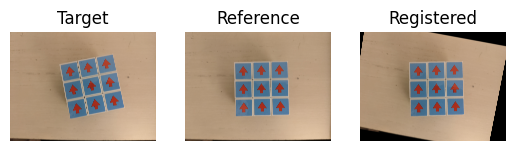

In [2]:
im_target="img/3x3_cube_target2.jpg"
im_ref="img/3x3_cube_ref2.jpg"

#1> calculate homography matrix
homography_m = calculate_homography_matrix(im_target, im_ref)
print(homography_m)

#2> correct image orientation
im_corr = apply_homography_matrix(im_target, homography_m)

#visualize results
plt.subplot(1,3,1)
plt.title("Target")
im_init=plt.imread(im_target)
plt.axis('off')
plt.imshow(im_init)

plt.subplot(1,3,2)
plt.title("Reference")
im_reference=plt.imread(im_ref)
plt.axis('off')
plt.imshow(im_reference)

plt.subplot(1,3,3)
plt.title("Registered")
plt.imshow(im_corr)
plt.axis('off')
plt.show()

#### 3. Example: Register a series of images to the first image<a id="3"></a>

In [3]:
#1> Calculate homography matrix from a list of images w.r.t. first image (earliest date and time).

dir="img/series" #specify the directory where the images are located

lst_homography_matrix=calculate_homography_matrix_series(dir)

Number of matching features: 144
Homography matrix: [[ 1.19919015e+00  2.94698499e-01 -5.48461066e+01]
 [-6.88972543e-02  1.18055785e+00  2.62043929e+00]
 [ 2.58071755e-04  5.98454423e-04  1.00000000e+00]]
Number of matching features: 136
Homography matrix: [[ 8.88522103e-01  1.61304439e-01 -1.36522505e+01]
 [-1.43685183e-01  8.92617663e-01  2.71230186e+01]
 [-8.04470842e-05 -1.43879280e-04  1.00000000e+00]]
Number of matching features: 145
Homography matrix: [[ 9.50226446e-01  2.54891895e-02  6.63357938e+00]
 [ 4.20872979e-03  1.04634894e+00 -3.26139755e+00]
 [-1.04910866e-04  1.26162362e-04  1.00000000e+00]]
Number of matching features: 136
Homography matrix: [[ 1.06659072e+00  4.26489351e-01 -4.87272783e+01]
 [-1.69956996e-01  1.15409873e+00  2.05200883e+01]
 [ 1.43595038e-06  7.51496672e-04  1.00000000e+00]]
Number of matching features: 165
Homography matrix: [[ 9.91295270e-01  4.73616997e-02 -9.21977649e+00]
 [-3.09630782e-02  1.03323384e+00 -1.75735658e-01]
 [-1.00046166e-04  1.0

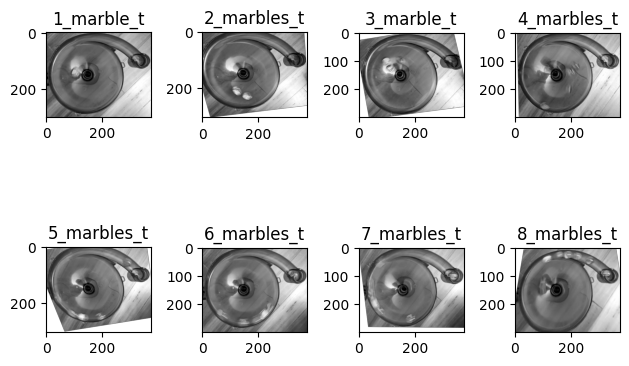

In [4]:
#2> Apply each matrix to each of the images w.r.t the reference.

import matplotlib.pyplot as plt

lst_files=[file for file in glob.glob("%s/*.*" %(dir))] #get the list of files in the specified directory

#plot the first (reference) image.
plt.subplot(2,int(len(lst_files)/2),1)

img1=plt.imread(lst_files[0])

img_title=lst_files[0].split("/")[-1].split("\\")[-1].split(".")[0]
plt.title(img_title)
plt.imshow(img1)

for i, file in enumerate(lst_files[1:]):
    new_img = apply_homography_matrix(file, lst_homography_matrix[i])
    #print(new_img)
    #print(img_title)
    
    plt.subplot(2,int(len(lst_files)/2), i+2)
    
    img_title=file.split("/")[-1].split("\\")[-1].split(".")[0]
    plt.title(img_title)
    plt.imshow(new_img)

plt.tight_layout()
plt.show()

***